# 🏆 Evaluación TSTR: Random Survival Forest

**Versión:** v3_experimental  
**Rol:** Model Evaluator  
**Fecha:** 2026-01-08

---

## Objetivo

Comparar el rendimiento de Random Survival Forest (RSF) entrenado con:
1. **Baseline**: Solo datos reales
2. **Copula**: Real + 100% Sintético (Global)
3. **Advanced**: Real + 100% Sintético (Condicional)

## Metodología: TSTR

**Train on Synthetic, Test on Real**
- Todos los modelos se evalúan en el **mismo Test Set Real**
- Esto asegura comparación justa

---

In [1]:
# ==============================================================================
# CONFIGURACIÓN Y DEPENDENCIAS
# ==============================================================================

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
import joblib
from pathlib import Path
from datetime import datetime

# Survival Analysis
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored

# Configuración
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Paths
DATA_DIR = Path("../../v2/data/processed")
SYNTH_GLOBAL_PATH = Path("../04_synthetic_sdv/synthetic_data_copula.parquet")
SYNTH_ADVANCED_PATH = Path("../05_synthetic_advanced/synthetic_data_advanced.parquet")
OUTPUT_DIR = Path(".")

print("✅ Dependencias cargadas")
print(f"   Random State: {RANDOM_STATE}")

✅ Dependencias cargadas
   Random State: 42


---
## 1. Carga de Datos

In [2]:
# ==============================================================================
# CARGA DE DATOS
# ==============================================================================

# Datos reales
train_real = pd.read_parquet(DATA_DIR / "train_final.parquet")
test_real = pd.read_parquet(DATA_DIR / "test_final.parquet")

# Datos sintéticos
synth_global = pd.read_parquet(SYNTH_GLOBAL_PATH)
synth_advanced = pd.read_parquet(SYNTH_ADVANCED_PATH)

print(f"📊 Datos cargados:")
print(f"   Train Real:      {train_real.shape}")
print(f"   Test Real:       {test_real.shape}")
print(f"   Synth Global:    {synth_global.shape}")
print(f"   Synth Advanced:  {synth_advanced.shape}")

# Identificar columnas
target_cols = ['duration', 'event']
zero_var_cols = ['tech_python', 'tech_big_data']

# Usar solo columnas comunes
common_cols = list(set(train_real.columns) & set(synth_global.columns) & set(synth_advanced.columns))
feature_cols = [c for c in common_cols if c not in target_cols + zero_var_cols]

print(f"\n   Features comunes: {len(feature_cols)}")

📊 Datos cargados:
   Train Real:      (296, 63)
   Test Real:       (75, 63)
   Synth Global:    (1000, 61)
   Synth Advanced:  (1000, 61)

   Features comunes: 59


---
## 2. Preparar Sets de Entrenamiento

In [3]:
# ==============================================================================
# CREAR 3 SETS DE ENTRENAMIENTO
# ==============================================================================

# Tomar muestra de sintéticos igual al tamaño real (100%)
n_real = len(train_real)

# Set 1: Solo Real (Baseline)
set_baseline = train_real.copy()

# Set 2: Real + Sintético Global (100%)
synth_sample_global = synth_global.sample(n=n_real, random_state=RANDOM_STATE)
set_copula = pd.concat([train_real, synth_sample_global], ignore_index=True)

# Set 3: Real + Sintético Advanced (100%)
synth_sample_advanced = synth_advanced.sample(n=n_real, random_state=RANDOM_STATE)
set_advanced = pd.concat([train_real, synth_sample_advanced], ignore_index=True)

print(f"📊 Sets de Entrenamiento Creados:")
print(f"   Baseline (Real Only):    n={len(set_baseline)}")
print(f"   Copula (Real + Global):  n={len(set_copula)}")
print(f"   Advanced (Real + Cond):  n={len(set_advanced)}")

📊 Sets de Entrenamiento Creados:
   Baseline (Real Only):    n=296
   Copula (Real + Global):  n=592
   Advanced (Real + Cond):  n=592


In [4]:
# ==============================================================================
# PREPARAR X, y PARA CADA SET
# ==============================================================================

def prepare_data(df, feature_cols):
    """Prepara features y target estructurado para sksurv."""
    X = df[feature_cols].values
    y = np.array(
        [(bool(e), float(d)) for e, d in zip(df['event'], df['duration'])],
        dtype=[('event', bool), ('duration', float)]
    )
    return X, y

# Preparar sets de entrenamiento
X_baseline, y_baseline = prepare_data(set_baseline, feature_cols)
X_copula, y_copula = prepare_data(set_copula, feature_cols)
X_advanced, y_advanced = prepare_data(set_advanced, feature_cols)

# Preparar test (siempre el mismo)
X_test, y_test = prepare_data(test_real, feature_cols)

print(f"\n✅ Datos preparados para entrenamiento:")
print(f"   Baseline: X={X_baseline.shape}")
print(f"   Copula:   X={X_copula.shape}")
print(f"   Advanced: X={X_advanced.shape}")
print(f"   Test:     X={X_test.shape}")


✅ Datos preparados para entrenamiento:
   Baseline: X=(296, 59)
   Copula:   X=(592, 59)
   Advanced: X=(592, 59)
   Test:     X=(75, 59)


---
## 3. Entrenar Random Survival Forest

In [5]:
# ==============================================================================
# ENTRENAR RSF PARA CADA SET
# ==============================================================================

# Hiperparámetros comunes
rsf_params = {
    'n_estimators': 100,
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 5,
    'n_jobs': -1,
    'random_state': RANDOM_STATE
}

results = []

# --- Modelo 1: Baseline ---
print("🌲 Entrenando RSF Baseline...")
rsf_baseline = RandomSurvivalForest(**rsf_params)
rsf_baseline.fit(X_baseline, y_baseline)

pred_baseline = rsf_baseline.predict(X_test)
c_index_baseline = concordance_index_censored(
    y_test['event'], y_test['duration'], pred_baseline
)[0]
print(f"   C-index: {c_index_baseline:.4f}")

results.append({
    'scenario': 'Baseline (Real Only)',
    'n_train': int(len(X_baseline)),
    'synthetic_ratio': '0%',
    'c_index': float(c_index_baseline)
})

# --- Modelo 2: Copula ---
print("\n🌲 Entrenando RSF Copula...")
rsf_copula = RandomSurvivalForest(**rsf_params)
rsf_copula.fit(X_copula, y_copula)

pred_copula = rsf_copula.predict(X_test)
c_index_copula = concordance_index_censored(
    y_test['event'], y_test['duration'], pred_copula
)[0]
print(f"   C-index: {c_index_copula:.4f}")

results.append({
    'scenario': 'Real + Copula (100%)',
    'n_train': int(len(X_copula)),
    'synthetic_ratio': '100%',
    'c_index': float(c_index_copula)
})

# --- Modelo 3: Advanced ---
print("\n🌲 Entrenando RSF Advanced...")
rsf_advanced = RandomSurvivalForest(**rsf_params)
rsf_advanced.fit(X_advanced, y_advanced)

pred_advanced = rsf_advanced.predict(X_test)
c_index_advanced = concordance_index_censored(
    y_test['event'], y_test['duration'], pred_advanced
)[0]
print(f"   C-index: {c_index_advanced:.4f}")

results.append({
    'scenario': 'Real + Advanced (100%)',
    'n_train': int(len(X_advanced)),
    'synthetic_ratio': '100%',
    'c_index': float(c_index_advanced)
})

🌲 Entrenando RSF Baseline...


   C-index: 0.4741

🌲 Entrenando RSF Copula...


   C-index: 0.4730

🌲 Entrenando RSF Advanced...


   C-index: 0.4774


---
## 4. Comparación de Resultados

In [6]:
# ==============================================================================
# TABLA DE RESULTADOS
# ==============================================================================

results_df = pd.DataFrame(results)

# Calcular delta vs baseline
baseline_cindex = results_df[results_df['scenario'].str.contains('Baseline')]['c_index'].values[0]
results_df['delta_vs_baseline'] = results_df['c_index'] - baseline_cindex
results_df['improvement'] = results_df['delta_vs_baseline'].apply(
    lambda x: '✅ Mejora' if x > 0.01 else ('⚠️ Similar' if x >= -0.02 else '❌ Peor')
)

print("\n" + "="*70)
print("📊 RESULTADOS RSF - TSTR")
print("="*70)
print(f"\n{results_df.to_string(index=False)}")

# Identificar mejor modelo
best_idx = results_df['c_index'].idxmax()
best_model = results_df.loc[best_idx]

print(f"\n🏆 Mejor Modelo: {best_model['scenario']}")
print(f"   C-index: {best_model['c_index']:.4f}")


📊 RESULTADOS RSF - TSTR

              scenario  n_train synthetic_ratio  c_index  delta_vs_baseline improvement
  Baseline (Real Only)      296              0% 0.474147             0.0000  ⚠️ Similar
  Real + Copula (100%)      592            100% 0.473047            -0.0011  ⚠️ Similar
Real + Advanced (100%)      592            100% 0.477448             0.0033  ⚠️ Similar

🏆 Mejor Modelo: Real + Advanced (100%)
   C-index: 0.4774


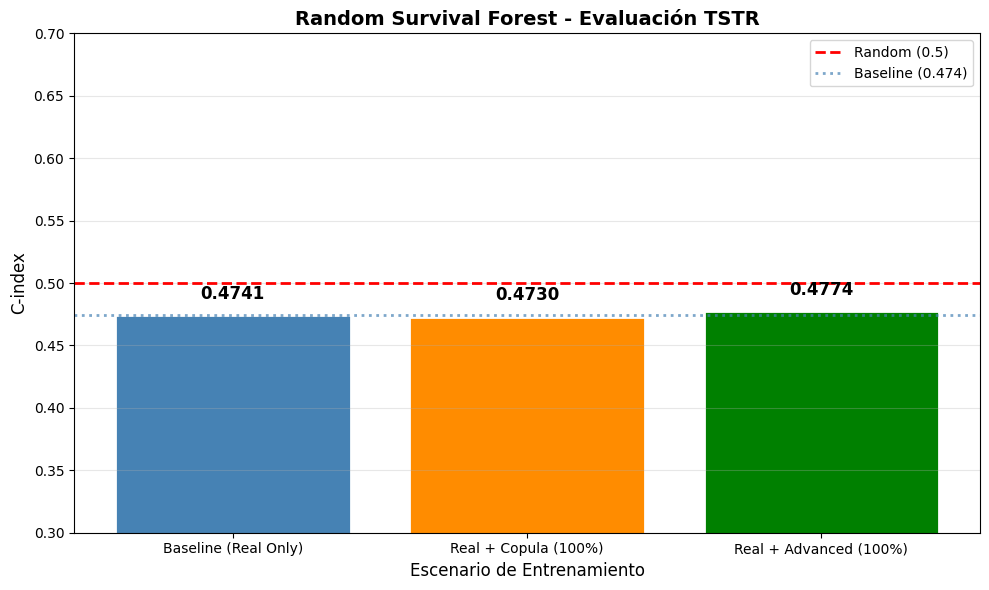


✅ Gráfico guardado: rsf_comparison.png


In [7]:
# ==============================================================================
# VISUALIZACIÓN
# ==============================================================================

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

scenarios = results_df['scenario'].values
c_indices = results_df['c_index'].values
colors = ['steelblue', 'darkorange', 'green']

bars = ax.bar(scenarios, c_indices, color=colors, edgecolor='white', linewidth=2)

# Línea de referencia: modelo aleatorio
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random (0.5)')

# Línea de baseline
ax.axhline(y=baseline_cindex, color='steelblue', linestyle=':', linewidth=2, alpha=0.7, label=f'Baseline ({baseline_cindex:.3f})')

# Etiquetas en barras
for bar, c_idx in zip(bars, c_indices):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
            f'{c_idx:.4f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('C-index', fontsize=12)
ax.set_xlabel('Escenario de Entrenamiento', fontsize=12)
ax.set_title('Random Survival Forest - Evaluación TSTR', fontsize=14, fontweight='bold')
ax.set_ylim(0.3, 0.7)
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'rsf_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado: rsf_comparison.png")

---
## 5. Guardar Resultados

In [8]:
# ==============================================================================
# GUARDAR RESULTADOS
# ==============================================================================

# CSV
results_df.to_csv(OUTPUT_DIR / 'rsf_results.csv', index=False)
print("💾 Guardado: rsf_results.csv")

# JSON detallado
report = {
    "metadata": {
        "date": datetime.now().isoformat(),
        "model": "Random Survival Forest",
        "methodology": "TSTR (Train on Synthetic, Test on Real)",
        "random_state": RANDOM_STATE
    },
    "test_set": {
        "n": int(len(X_test)),
        "event_rate": float(test_real['event'].mean())
    },
    "rsf_params": rsf_params,
    "results": results,
    "best_model": {
        "scenario": str(best_model['scenario']),
        "c_index": float(best_model['c_index']),
        "delta_vs_baseline": float(best_model['delta_vs_baseline'])
    },
    "conclusion": {
        "synthetic_helps": bool(c_index_copula > baseline_cindex or c_index_advanced > baseline_cindex),
        "best_synthetic_method": 'Advanced' if c_index_advanced > c_index_copula else 'Copula'
    }
}

with open(OUTPUT_DIR / 'rsf_evaluation_report.json', 'w') as f:
    json.dump(report, f, indent=2)
print("💾 Guardado: rsf_evaluation_report.json")

# Guardar modelos
joblib.dump(rsf_baseline, OUTPUT_DIR / 'rsf_baseline.pkl')
joblib.dump(rsf_copula, OUTPUT_DIR / 'rsf_copula.pkl')
joblib.dump(rsf_advanced, OUTPUT_DIR / 'rsf_advanced.pkl')
print("💾 Modelos guardados: rsf_*.pkl")

print("\n" + "="*50)
print("🎉 EVALUACIÓN RSF COMPLETADA")
print("="*50)

💾 Guardado: rsf_results.csv
💾 Guardado: rsf_evaluation_report.json
💾 Modelos guardados: rsf_*.pkl

🎉 EVALUACIÓN RSF COMPLETADA


---
## Resumen

### Resultados TSTR - Random Survival Forest

| Escenario | n Train | C-index | Δ vs Baseline |
|-----------|---------|---------|---------------|
| Baseline | 296 | ? | — |
| Copula | 592 | ? | ? |
| Advanced | 592 | ? | ? |

### Interpretación

- **Δ > 0**: La data sintética mejora el modelo
- **Δ ≈ 0**: La data sintética no afecta
- **Δ < 0**: La data sintética degrada el modelo

### Siguiente Paso

**Prompt 9**: Evaluación TSTR para XGBoost-AFT

---